In [1]:
%pip install Sastrawi
import nltk
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

import pandas as pd
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import re
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from transformers import TFBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.preprocessing import LabelEncoder

label_type = ['negative', 'positive']

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  i

2024-06-09 10:27:18.132677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 10:27:18.132783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 10:27:18.270057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = pd.read_csv('/kaggle/input/indooo/indo.csv')
data['Text'] = data['Text'].astype(str)
texts = data['Text'].values
labels = data['Sentiment'].values

In [3]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
stopwords += custom_stopwords

pattern = r"[^A-Za-z ]"

lemmatizer = WordNetLemmatizer()

def preprocess_text(texts):
    for index, text in enumerate(texts):
        text = text.lower()

        text = re.sub(pattern, '', text)

        word_list = word_tokenize(text)
        word_list = [word for word in word_list if word not in stopwords]

        word_list = [lemmatizer.lemmatize(word) for word in word_list]

        text = ' '.join(word_list)
        texts[index] = text
    return texts

In [4]:
texts = preprocess_text(texts)

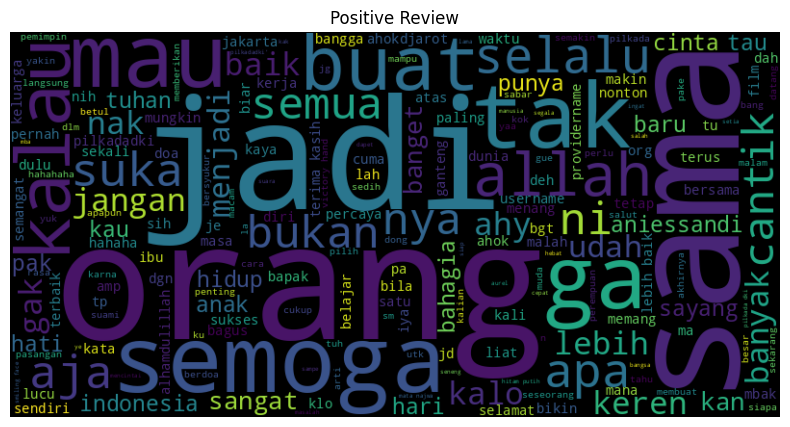

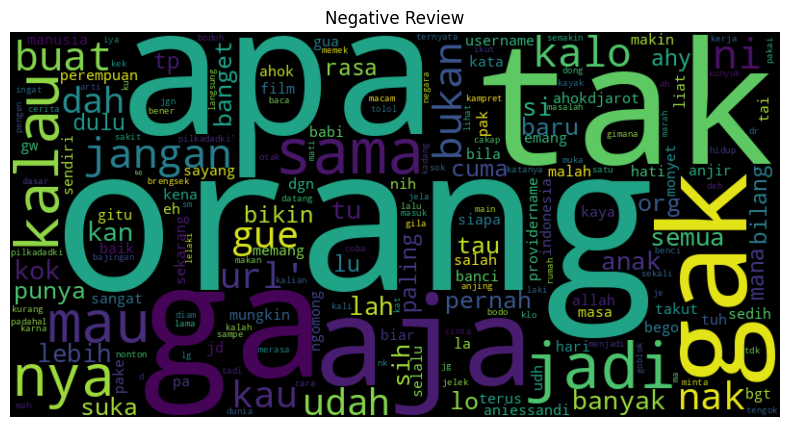

In [5]:
def generate_wordcloud(text,Title):
    all_text = "".join(str(text))
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()
    
positive = texts[labels=='positive'].tolist()
generate_wordcloud(positive,'Positive Review')

negative = texts[labels=='negative'].tolist()
generate_wordcloud(negative,'Negative Review')

In [14]:
train_texts, tests_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2)

In [15]:
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')

def tokenize_function(texts):
    return tokenizer(texts,padding=True,truncation=True, return_tensors='tf', max_length=512)

train_encodings = tokenize_function(train_texts.tolist())
test_encodings = tokenize_function(tests_texts.tolist())

In [16]:
le = LabelEncoder()

train_labels = le.fit_transform(train_labels)
test_labels = le.fit_transform(test_labels)

In [17]:
model = TFBertForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', num_labels=2, from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.rate = 0.2

In [19]:
epochs = 2
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [20]:
history = model.fit(
    [train_encodings['input_ids'], train_encodings['token_type_ids'], train_encodings['attention_mask']],
    train_labels, validation_split = 0.1,
    batch_size=16,
    epochs=epochs
)

Epoch 1/2
414/414 [==============================] - 234s 405ms/step - loss: 0.4613 - accuracy: 0.7791 - val_loss: 0.3352 - val_accuracy: 0.8531
Epoch 2/2
414/414 [==============================] - 155s 374ms/step - loss: 0.2908 - accuracy: 0.8818 - val_loss: 0.3539 - val_accuracy: 0.8531


58/58 [==============================] - 19s 134ms/step
Accuracy Score: 0.8638344226579521
Recall Score: 0.8161490683229814
Precision Score: 0.8656126482213439
F1 Score: 0.840153452685422
Classification Report:               precision    recall  f1-score   support

    negative       0.90      0.86      0.88      1077
    positive       0.82      0.87      0.84       759

    accuracy                           0.86      1836
   macro avg       0.86      0.86      0.86      1836
weighted avg       0.87      0.86      0.86      1836

Confusion Matrix:



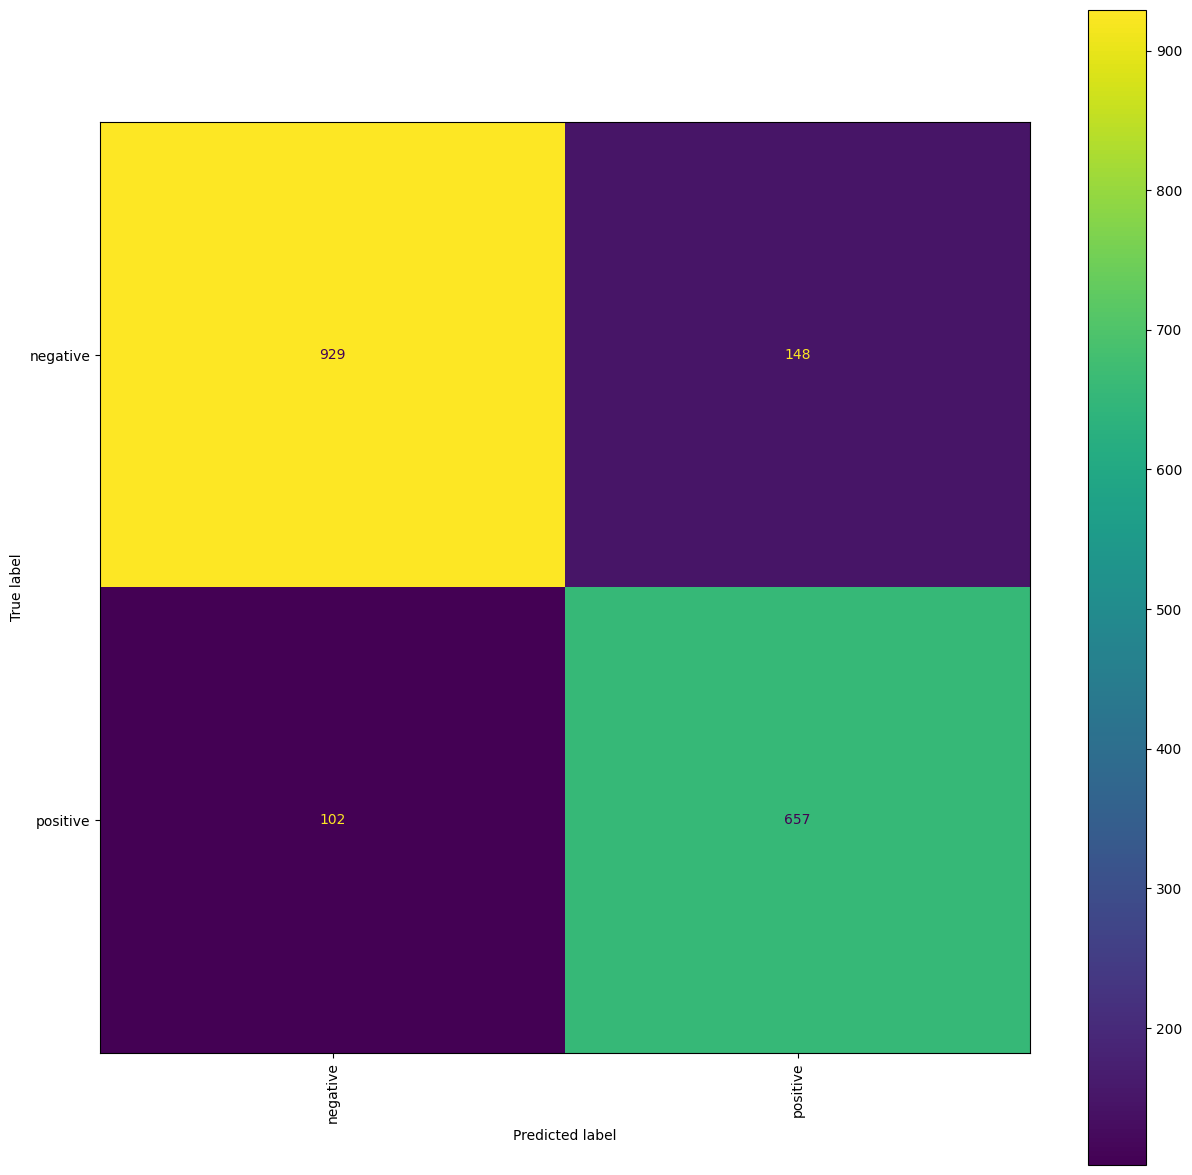

In [21]:
pred = model.predict([test_encodings['input_ids'], test_encodings['token_type_ids'], test_encodings['attention_mask']])
pred_labels = tf.argmax(pred.logits, axis=1)

print(f"Accuracy Score: {accuracy_score(pred_labels, test_labels)}")
print(f"Recall Score: {recall_score(pred_labels, test_labels)}")
print(f"Precision Score: {precision_score(pred_labels, test_labels)}")
print(f"F1 Score: {f1_score(pred_labels, test_labels)}")
print(f"Classification Report: {classification_report(test_labels, pred_labels, target_names=label_type)}")

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, pred_labels), display_labels = label_type)

fig, ax = plt.subplots(figsize=(15,15))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')

In [22]:
model.save_pretrained('sentiment_model')

In [23]:
sentiment_model = TFBertForSequenceClassification.from_pretrained('sentiment_model')
spam_identification_model = TFBertForSequenceClassification.from_pretrained('/kaggle/input/spam-identification-indobert/tensorflow1/model/1/spam_identification_model')

Some layers from the model checkpoint at sentiment_model were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at sentiment_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
Some layers from the model checkpoint at /kaggle/input/spam-identification-indo

In [30]:
spam_label_type = ['ham', 'spam']
def predict_sentiment(text):
    use_text = preprocess_text(text)
    encoding = tokenize_function(use_text)
    pred = sentiment_model.predict([encoding['input_ids'], encoding['token_type_ids'], encoding['attention_mask']])
    pred_labels = tf.argmax(pred.logits, axis=1)
    spam_pred = spam_identification_model.predict([encoding['input_ids'], encoding['token_type_ids'], encoding['attention_mask']])
    spam_pred_labels = pred_labels = tf.argmax(spam_pred.logits, axis=1)

    pred_labels = [label_type[i] for i in pred_labels.numpy().tolist()]
    spam_pred_labels = [spam_label_type[i] for i in spam_pred_labels.numpy().tolist()]
    for index, pred in enumerate(pred_labels):
        print(f"{text[index]}\nPrediction: {pred}, {spam_pred_labels[index]} {spam_pred}\n\n")


In [34]:
predict_sentiment(['Banyak akun kloning seolah2 pendukung #agussilvy mulai menyerang paslon #aniessandi dengan opini dan argumen pmbenaran..jangan terkecoh',
                  'Mari beri masukan & kritik yang membangun bagi yang kalah dalam pertandingan. #PilkadaSerentak2017 #ahokdjarot #agussilvy #AniesSandi'])

1/1 [==============================] - 0s 41ms/step
banyak akun kloning pendukung agussilvy mulai menyerang paslon aniessandi opini argumen pmbenaranjangan terkecoh
Prediction: positive, spam TFSequenceClassifierOutput(loss=None, logits=array([[-0.6812347 ,  1.3211864 ],
       [-0.35703325,  0.97000664]], dtype=float32), hidden_states=None, attentions=None)


beri masukan kritik membangun kalah pertandingan pilkadaserentak ahokdjarot agussilvy aniessandi
Prediction: positive, spam TFSequenceClassifierOutput(loss=None, logits=array([[-0.6812347 ,  1.3211864 ],
       [-0.35703325,  0.97000664]], dtype=float32), hidden_states=None, attentions=None)




In [ ]:
tes = pd.read_csv('/kaggle/input/pilkada/dataset_tweet_sentiment_pilkada_DKI_2017.csv')
texts = []
for index, data in tes.iterrows():
    texts.extend(preprocess_text([data['Text Tweet']]))
encoding = tokenize_function(texts)
pred = model.predict([encoding['input_ids'], encoding['token_type_ids'], encoding['attention_mask']])
pred_labels = tf.argmax(pred.logits, axis=1)

# pred_labels = [labels[i] for i in pred_labels.numpy().tolist()]

y = tes['Sentiment']
le = LabelEncoder()
y = le.fit_transform(y)

print(accuracy_score(y, pred_labels))
print(pred_labels)

27/29 [==========================>...] - ETA: 0s